In [34]:
!git clone https://github.com/devkotasawal1/Poem-Generator

fatal: destination path 'Poem-Generator' already exists and is not an empty directory.


In [35]:
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import time

In [36]:
path_to_file = "combined.txt"

In [37]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 155334 characters


In [38]:
print(text[:250])

नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,
मनको वनमा ननिभ्ने गरी विरह जलाई !
ननिभ्ने गरी विरह जलाई,
लोचनका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !
के भनूँ? भन्ने म केही थिइन  विष नै पिलाए !
प्यारा ! विष नै पिलाए !
मनको कुरा गलामा अड्छ, अड्कन्छ गलामा,
य


In [39]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

83 unique characters


In [40]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [41]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '(' :   3,
  ')' :   4,
  ',' :   5,
  '-' :   6,
  '.' :   7,
  ':' :   8,
  ';' :   9,
  '?' :  10,
  'm' :  11,
  '¥' :  12,
  '«' :  13,
  'ँ' :  14,
  'ं' :  15,
  'ः' :  16,
  'अ' :  17,
  'आ' :  18,
  'इ' :  19,
  ...
}


In [42]:
# Show how the first 13 characters from the text are mapped to integers
print('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'नछाडी जानोस् ' ---- characters mapped to int ---- > [47 34 61 40 63  1 35 61 47 69 59 71  1]


In [43]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length + 1)
examples_per_epoch

1537

In [44]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

न
छ
ा
ड
ी


In [45]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह जलाई !\nननिभ्ने गरी विरह जलाई,\nलोच'
'नका तारा ! हे मेर प्यारा ! यो जोति  बिलाए !\nके भनूँ? भन्ने म केही थिइन  विष नै पिलाए !\nप्यारा ! विष न'
'ै पिलाए !\nमनको कुरा गलामा अड्छ, अड्कन्छ गलामा,\nयो मेरो मुटु पचासबाजी धड्कन्छ पलामा ।\nयो छाती मेरो चिर'
'ेर खोली नजर गराए,\nत्यो मन केही फर्कंदो होला, तस्विर खुलाए\nआँसुमा खस्छ मनको टुक्रा यो आँसु बोल्दैन,\nमन'
'को कुरा मनमै बस्छ, छातिले खोल्दैन,\nप्यारा ! आँसुले बोल्दैन !\nहे मेरी मुना ! नभन त्यसो, जूनमा फुलेकी !'


In [46]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [47]:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'नछाडी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह जलाई !\nननिभ्ने गरी विरह जलाई,\nलो'
Target data: 'छाडी जानोस् हे मेरा प्राण ! अकेली मलाई,\nमनको वनमा ननिभ्ने गरी विरह जलाई !\nननिभ्ने गरी विरह जलाई,\nलोच'


In [48]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [49]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024
vocab_size

83

In [50]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [51]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [52]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 83) # (batch_size, sequence_length, vocab_size)


In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 256)           21248     
                                                                 
 gru_2 (GRU)                 (64, None, 1024)          3938304   
                                                                 
 dense_2 (Dense)             (64, None, 83)            85075     
                                                                 
Total params: 4,044,627
Trainable params: 4,044,627
Non-trainable params: 0
_________________________________________________________________


In [54]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [55]:
sampled_indices

array([ 8, 30, 67, 64, 27, 69, 43, 43, 51, 29, 53,  4, 35, 50, 66, 27,  6,
       39, 44, 72, 76, 17, 47, 79, 58, 14, 71, 42, 58, 76, 75, 78, 38, 45,
       59, 66, 26, 61, 55, 16, 52,  7, 25, 46, 48, 55, 21, 57,  4,  3, 45,
       36, 35, 12, 40, 65, 49, 35, 28, 56, 71, 21, 41, 34, 13, 81, 22, 15,
        6,  9, 62, 19, 63, 75, 49, 45,  5, 50, 12, 19, 69, 24, 43, 77, 59,
        5, 72, 67, 59, 53, 40, 73, 11, 62, 39, 25, 82, 56, 55, 38])

In [56]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 ' मेरो गीत !\nशिल्पित उपलको वेलीवनमा,\nयो रुह बुलबुल,\nघनले निलेकी शशिकन सम्झी,\nबोली रहला युगका यात्री\nस'

Next Char Predictions: 
 ':गेुऔोततभखय)जबृऔ-ठथॐ–अन’षँ्णष–\u200d‘टदसृओालःम.ऐधपलउश)(दझज¥डूफजकव्उढछ«”ऊं-;िइी\u200dफद,ब¥इोएत—स,ॐेसयड।mिठऐ…वलट'


In [57]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.419906


In [58]:
model.compile(optimizer='adam', loss=loss, metrics = ['acc'])

In [59]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

In [60]:
EPOCHS = 60

In [61]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/60
24/24 [==============================] - 6s 153ms/step - loss: 4.1886 - acc: 0.1036
Epoch 2/60
24/24 [==============================] - 4s 146ms/step - loss: 3.3501 - acc: 0.1755
Epoch 3/60
24/24 [==============================] - 4s 142ms/step - loss: 2.9450 - acc: 0.2426
Epoch 4/60
24/24 [==============================] - 4s 141ms/step - loss: 2.7646 - acc: 0.2582
Epoch 5/60
24/24 [==============================] - 4s 139ms/step - loss: 2.6933 - acc: 0.2685
Epoch 6/60
24/24 [==============================] - 4s 140ms/step - loss: 2.6448 - acc: 0.2756
Epoch 7/60
24/24 [==============================] - 4s 139ms/step - loss: 2.6016 - acc: 0.2887
Epoch 8/60
24/24 [==============================] - 4s 139ms/step - loss: 2.5608 - acc: 0.2976
Epoch 9/60
24/24 [==============================] - 4s 139ms/step - loss: 2.5170 - acc: 0.3087
Epoch 10/60
24/24 [==============================] - 4s 145ms/step - loss: 2.4761 - acc: 0.3201
Epoch 11/60
24/24 [==============================

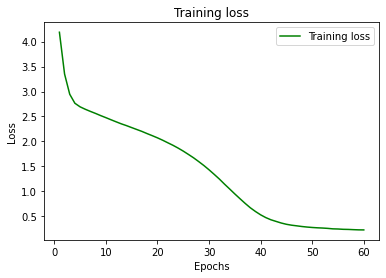

In [62]:
loss_train = history.history['loss']
epochs = range(1,len(history.history['acc'])+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [64]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_60'

In [65]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [67]:
print(generate_text(model, start_string="हे मेरी मुना"))

हे मेरी मुना ! ओह !
असि यह्नो लटको रो !
छाती, पङ्ख मानीका रुखहरु
लिर दर्दा सुनौला मनोषगरमाथि कि बिचिता रे !
सुनेछ सत्यक्री कोलिलाई,
हो अमिटर खोइ !”
के गरी छहिँली !
र माइ वन गर्दिन्छ ।
अत्रनाकन
र अमृतको जाल चिन्ती लिचात
महाँ देखेर तर्साई,
महान दिल किन म शिर हो, भोम तारी, तानाए छालेकी !
विशाल व्यङ्ग्य केवल !
रातले रोइरहिन, पार्वती भेट्न थालेँ ।
“ङ्कृति नीतै !
भेटेन वयौँ
दिनभरि रे !
खिल्ली पद्य छौ !
म तरले छाती चिर्दै 
चामल एक मुठी ।
 जीवनभरको एक पुकारा 
चामल एक मुठी ।
 मानिससँगमा मानिस हुँछुँदैनौ तिम्रो खिदा छ सास,
एकमुखा सुत
सब बाबु तर्साउँछु दीप वदनी
एउटा कलिलो रहेछ
हामी बाँचिद्यान् अमर्यका रहस्? 
हेर ढो ली पहेँला कोटा दाखता,
समाज्न प्रभातको कहानी,
आजैको यो येगअघि खडा, डाक्न खोज्छे जवानी,
के रो मयाँडामा अब बहुली !
र नमाभित्र तिम्रनेछ म दगत्त्यौ यस जगतिर भन्ने,
मिली उठयौं उस जगतिर भन्ने
भस्म मस्तो विकसिर अनि स्फुली गुमाएँ,
आमिको जीवन प्रत्येक व्यक्ति टन्न सकानमा निरन्तर झरबरमा राख तन रान्छ,
सुनिएँ !
नम्म भन्छु मानवचाचराहरु
पङ्खमा फाँचिएका
के त आज शौक भड्की ?
थर्री !
फर्किन अजीत !
म हुने